In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir, load_yaml
from aimanager.utils.array_to_df import using_multiindex, add_labels
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})


run = 'simple_2'

folder = f'../../train_data/manager/v3/{run}'

train_folder = os.path.join(folder, 'train')
merge_file = os.path.join(folder, 'merged.parquet')

plot_folder = f'plots/{run}'

make_dir(plot_folder)

/home/mpib/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [74]:
def parse_eval_file(folder):
    data_file = os.path.join(folder, 'data/eval.1000.pt')
    job_file = os.path.join(folder, 'job.yml')
    job = load_yaml(job_file)
    labels = job['labels']

    eval_th = th.load(data_file, map_location=th.device('cpu'))
    punishments = using_multiindex(eval_th['punishments'].numpy(), columns=['idx','round_number', 'agent'], value_name='punishments')
    common_good = using_multiindex(eval_th['common_good'].numpy(), columns=['idx','round_number', 'agent'], value_name='common_good')
    contributions = using_multiindex(eval_th['contributions'].numpy(), columns=['idx','round_number', 'agent'], value_name='contributions')
    payoffs = using_multiindex(eval_th['payoffs'].numpy(), columns=['idx','round_number', 'agent'], value_name='payoffs')
    episode = using_multiindex(eval_th['episode'].numpy(), columns=['idx','round_number'], value_name='episode')

    df = punishments.merge(common_good).merge(contributions).merge(payoffs).merge(episode)

    df = df.drop(columns=['idx', 'agent'])

    df = df.groupby(['episode','round_number']).mean().reset_index()

    df = df.melt(id_vars=['episode','round_number'], value_vars=['punishments', 'common_good', 'contributions', 'payoffs'], var_name='metric')
    df = add_labels(df, labels=labels)
    return df

In [75]:
if not os.path.isfile(merge_file):
    dfs = [parse_eval_file(os.path.join(train_folder, subfolder)) for subfolder in os.listdir(train_folder)]
    df = pd.concat(dfs)
    df.to_parquet(merge_file)
else:
    df = pd.read_parquet(merge_file)


In [76]:
labels = ['eps', 'gamma', 'lr', 'model']

df['label_str'] = '|'
for l in labels:
    df['label_str'] += f"{l}=" + df[l].astype(str) + "|"

In [77]:
df.columns

Index(['eps', 'gamma', 'lr', 'model', 'episode', 'round_number', 'metric',
       'value', 'label_str'],
      dtype='object')

In [78]:
# w = (
#     (df['episode'] == df['episode'].max()) & 
#     (df['metric'] == 'common_good')
# )

# sns.catplot(data=df[w], y='label_str', x='value')

In [79]:
df['eps'].unique()

array([1. , 0.2, 0.1])

In [80]:
import statsmodels.formula.api as smf
w = (
    (df['episode'] == df['episode'].max()) & 
    (df['metric'] == 'contributions')
)
dfs = df[w].copy()

for l in labels:
    dfs[l] = dfs[l].astype(str)


label_ref = {
    'model': 'mlp',
    'eps': '0.1',
    'gamma': '1.0',
    'lr': '1.e-3',
    'model': 'mlp'
}


label_str = [f"C({l}, Treatment(reference='{label_ref[l]}'))" if l in label_ref else l for l in labels]





results = smf.glm(f"value ~ {'+'.join(label_str)}", data=dfs).fit()
results_df = results.summary2().tables[1]

# print('metric accuracy - positive coef -> better')
# results_df[results_df['P>|z|'] < 0.25].sort_values('P>|z|')
results_df

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,12.344546,0.181951,67.845453,0.000000e+00,11.987928,12.701163
"C(eps, Treatment(reference='0.1'))[T.0.2]",-1.043475,0.148562,-7.023820,2.158833e-12,-1.334652,-0.752298
"C(eps, Treatment(reference='0.1'))[T.1.0]",-1.534722,0.148562,-10.330493,5.129633e-25,-1.825899,-1.243545
"C(gamma, Treatment(reference='1.0'))[T.0.0]",-1.392265,0.171545,-8.116031,4.816781e-16,-1.728487,-1.056043
"C(gamma, Treatment(reference='1.0'))[T.0.5]",-0.502604,0.171545,-2.929867,3.391066e-03,-0.838826,-0.166382
"C(gamma, Treatment(reference='1.0'))[T.0.8]",-0.696470,0.171545,-4.059983,4.907622e-05,-1.032692,-0.360248
"C(lr, Treatment(reference='1.e-3'))[T.1.e-4]",1.096354,0.148562,7.379758,1.585773e-13,0.805177,1.387531
"C(lr, Treatment(reference='1.e-3'))[T.1.e-5]",2.308087,0.148562,15.536154,1.974860e-54,2.016911,2.599264
"C(model, Treatment(reference='mlp'))[T.rnn]",-0.088108,0.121301,-0.726358,4.676196e-01,-0.325853,0.149637


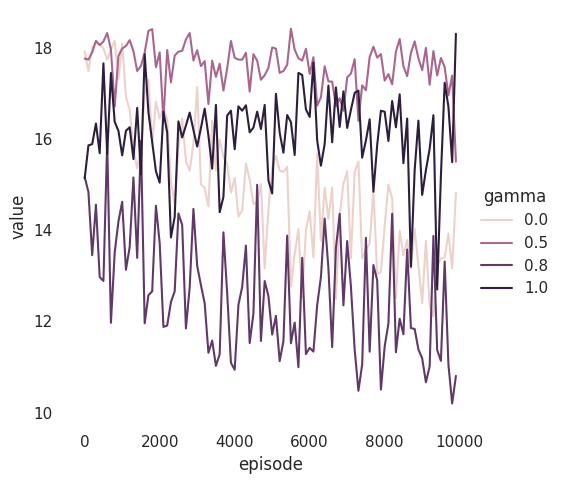

In [95]:
selection = {'eps': 0.1, 'gamma': 0.5, 'lr': '1.e-5', 'model': 'mlp', 'metric': 'contributions'}

focus = ['episode', 'gamma']

# selection = {k: v for k, v in ref.items() if k != focus}

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if k not in focus
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='line', ci=None)


# fg.set(ylabel='cross entropy')


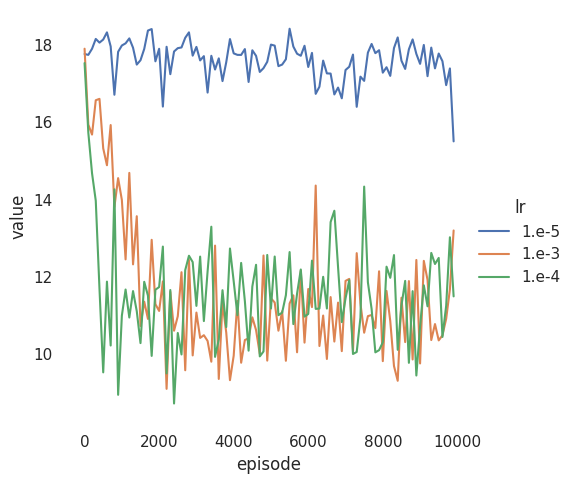

In [96]:
selection = {'eps': 0.1, 'gamma': 0.5, 'lr': '1.e-5', 'model': 'mlp', 'metric': 'contributions'}

focus = ['episode', 'lr']

# selection = {k: v for k, v in ref.items() if k != focus}

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if k not in focus
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='line', ci=None)
